# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [ ]:
# Optional, if using Google Colab w/ Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj1/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
import utils

In [ ]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
im1_file = datadir + 'bear.jpg'
im2_file = datadir + 'mitch.jpeg'

im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

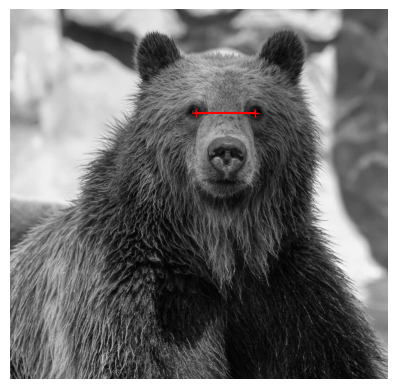

In [ ]:
pts_im1 = utils.prompt_eye_selection(im1)
# pts_im1 = np.array([[590, 350], [650, 350]]) # uncomment if entering [x, y] pts manually

# pts_im1 = np.array([[2330, 975], [2595, 975]]) # uncomment if entering [x, y] pts manually

pts_im1 = np.array([[530, 295], [700, 295]]) # bear

# pts_im1 = np.array([[390, 173], [455, 185]]) # clown


plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')
# print(pts_im1)

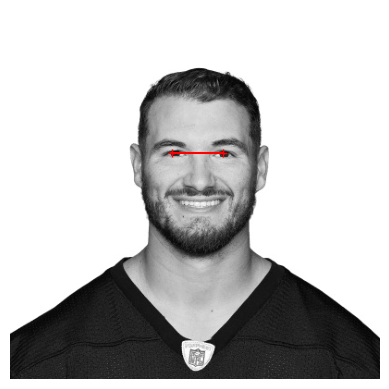

In [ ]:
pts_im2 = utils.prompt_eye_selection(im2)

# pts_im2 = np.array([[2300, 850], [2550, 850]]) # uncomment if entering [x, y] pts manually

# pts_im2 = np.array([[620, 360], [670, 360]]) # uncomment if entering [x, y] pts manually

pts_im2 = np.array([[175, 155], [230, 155]]) # mitch

# pts_im2 = np.array([[815, 490], [975, 475]]) # jerry

plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')


In [ ]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)


In [ ]:
# convert to grayscale
# im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB) / 255.0
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
# im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

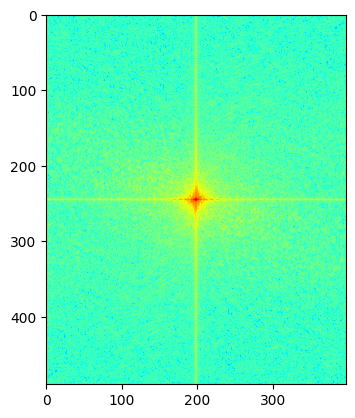

In [ ]:
fftmag = np.abs(np.fft.fftshift(np.fft.fft2(im1)))
plt.imshow(fftmag,norm=LogNorm(fftmag.min(),fftmag.max()),cmap='jet')

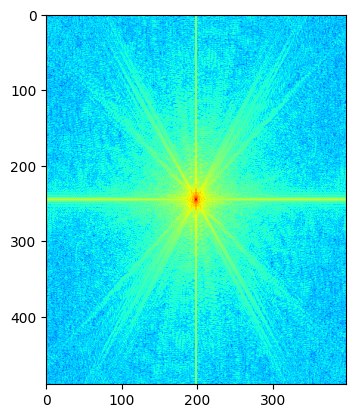

In [ ]:
fftmag = np.abs(np.fft.fftshift(np.fft.fft2(im2)))
plt.imshow(fftmag,norm=LogNorm(fftmag.min(),fftmag.max()),cmap='jet')

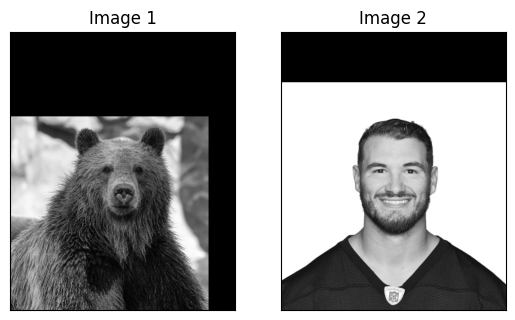

In [ ]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

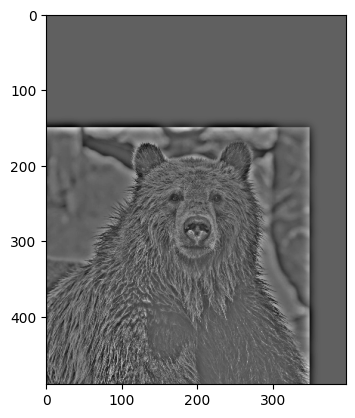

In [ ]:
sigma_high = 6

ksize2 = int(np.ceil(sigma_high)*6+1)
fil2 = cv2.getGaussianKernel(ksize2, sigma_high) # 1D kernel
fil2 = fil2*np.transpose(fil2) # 2D kernel by outer product
convolved_im1 = im1 - cv2.filter2D(im1, -1, fil2)

plt.imshow(convolved_im1, cmap='gray')


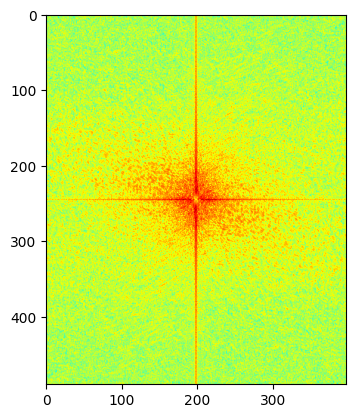

In [ ]:
fftmag = np.abs(np.fft.fftshift(np.fft.fft2(convolved_im1)))
plt.imshow(fftmag,norm=LogNorm(fftmag.min(),fftmag.max()),cmap='jet')

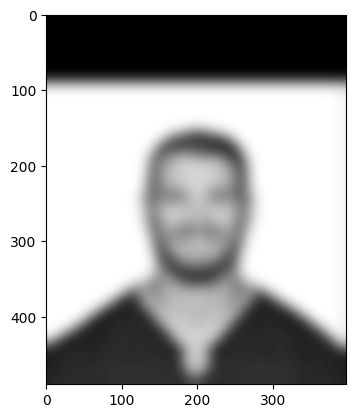

In [ ]:
sigma_low = 9

ksize = int(np.ceil(sigma_low)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma_low) # 1D kernel
fil = fil*np.transpose(fil) # 2D kernel by outer product
convolved_im2 = cv2.filter2D(im2, -1, fil)

plt.imshow(convolved_im2, cmap='gray')

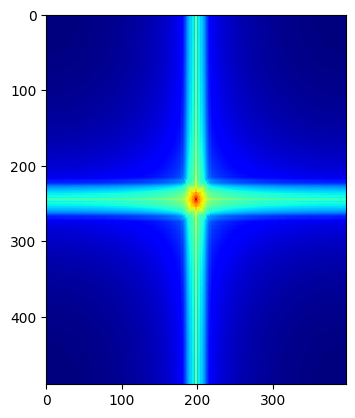

In [ ]:
fftmag = np.abs(np.fft.fftshift(np.fft.fft2(convolved_im2)))
plt.imshow(fftmag,norm=LogNorm(fftmag.min(),fftmag.max()),cmap='jet')

In [ ]:
def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter

    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''

    if len(im1.shape) == 2:
        im1 = np.stack((im1,) * 3, axis=-1)

    if len(im2.shape) == 2:
        im2 = np.stack((im2,) * 3, axis=-1)


    # low pass filter

    ksize = int(np.ceil(sigma_low)*6+1)
    fil = cv2.getGaussianKernel(ksize, sigma_low) # 1D kernel
    fil = fil*np.transpose(fil) # 2D kernel by outer product
    convolved_im1 = cv2.filter2D(im1, -1, fil)

    # high pass filter

    ksize2 = int(np.ceil(sigma_high)*6+1)
    fil2 = cv2.getGaussianKernel(ksize2, sigma_high) # 1D kernel
    fil2 = fil2*np.transpose(fil2) # 2D kernel by outer product
    convolved_im2 = im2 - cv2.filter2D(im2, -1, fil2)

    # convolved_im2 = np.clip(convolved_im2, 0, 1)
    # convolved_im2.astype(np.uint8)

    # Return the combination of both images, one filtered with a low-pass filter and the other with a high-pass filter.

    avg_img = cv2.addWeighted(convolved_im1, 0.5, convolved_im2, 0.5, 0)

    return avg_img




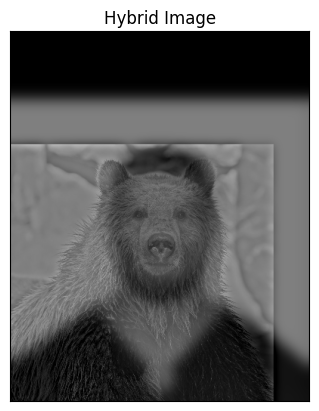

In [ ]:
sigma_low = 9 # choose parameters that work for your images
sigma_high = 6

im_hybrid = hybridImage(im2, im1, sigma_low, sigma_high)

# display im_hybrid
plt.imshow(im_hybrid)
plt.title('Hybrid Image'), plt.xticks([]), plt.yticks([]);

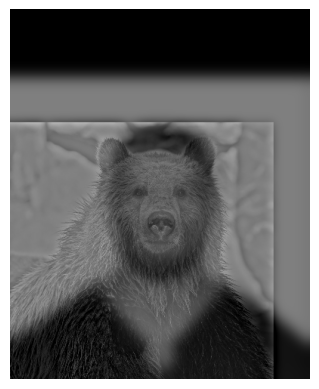

In [ ]:
__# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

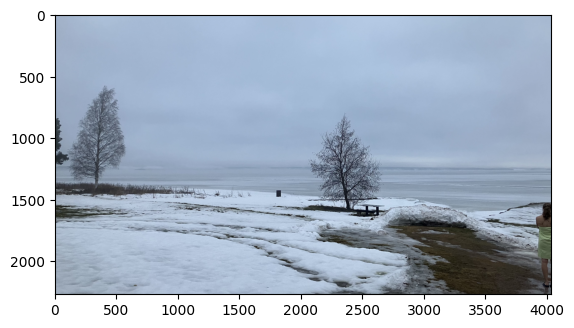

In [ ]:
im3_file = datadir + 'mora.jpeg'

im3 = cv2.imread(im3_file)
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))

In [ ]:
# Laplacian Filtering

In [ ]:
# Gamma Correction

# code was inspired by this post https://pyimagesearch.com/2015/10/05/opencv-gamma-correction/

def adjust_gamma(image, gamma):
	# build a lookup table mapping the pixel values [0, 255] to adjusted gamma values
	invGamma = 1.0 / gamma
	# using inverse gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

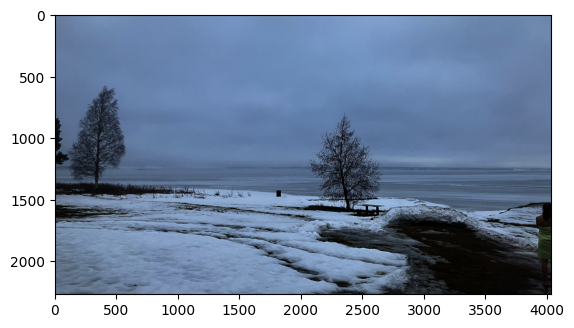

In [ ]:
im6 = adjust_gamma(im3, .5)
plt.imshow(cv2.cvtColor(im6, cv2.COLOR_BGR2RGB))

#### Color enhancement

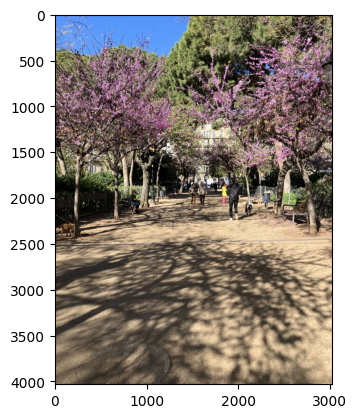

In [ ]:
im5_file = datadir + 'barca.jpeg'

im5 = cv2.imread(im5_file)
plt.imshow(cv2.cvtColor(im5, cv2.COLOR_BGR2RGB))

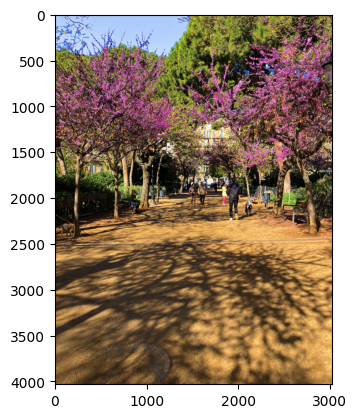

In [ ]:
hsv_to_rgb = cv2.cvtColor(im5,cv2.COLOR_BGR2HSV)

h = hsv_to_rgb[:,:,0]
s = hsv_to_rgb[:,:,1]
v = hsv_to_rgb[:,:,2]

s_new = s * 2

s_new = np.clip(s_new, 0, 255)

hsv_image = cv2.merge([h, s_new, v])
out = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

#### Color shift

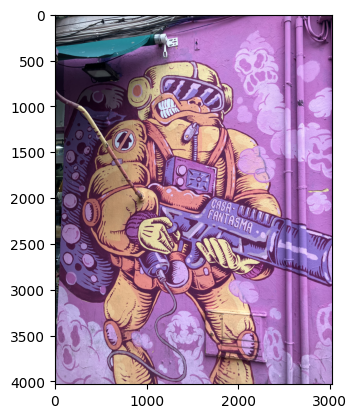

In [ ]:
im7_file = datadir + 'madrid.jpeg'

im7 = cv2.imread(im7_file)
plt.imshow(cv2.cvtColor(im7, cv2.COLOR_BGR2RGB))

In [ ]:
hsv = cv2.cvtColor(im7, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

In [ ]:
# Sources from https://stackoverflow.com/questions/49697363/shifting-hsv-pixel-values-in-python-using-numpy

h_mask = (h < 60)
h[h_mask] = (h[h_mask] + 90) % 180
shift_hsv = cv2.merge([h, s, v])
shift_img = cv2.cvtColor(shift_hsv, cv2.COLOR_HSV2BGR)

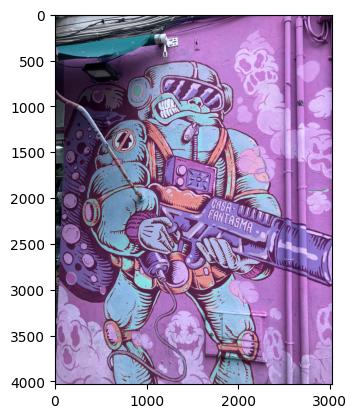

In [ ]:
plt.imshow(cv2.cvtColor(shift_img, cv2.COLOR_BGR2RGB))

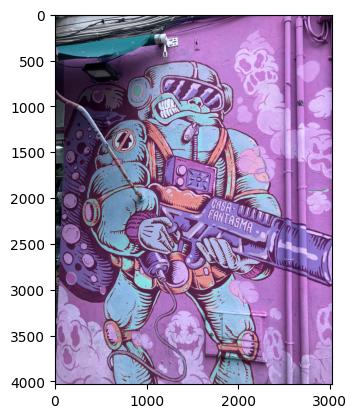

In [100]:
plt.imshow(cv2.cvtColor(shift_img, cv2.COLOR_BGR2RGB))

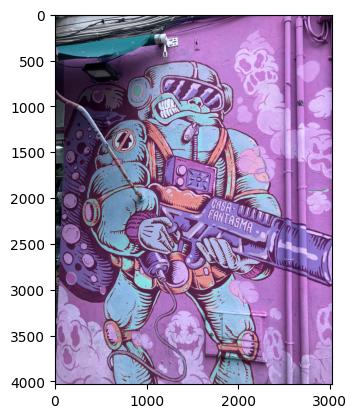

In [101]:
plt.imshow(cv2.cvtColor(shift_img, cv2.COLOR_BGR2RGB))